IMPORT DEPENDENCES

In [54]:
from pyspark.sql import SparkSession
import pandas as pd
import pyspark.sql.functions as F

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [57]:
spark

In [58]:
df = spark.read.csv("./data/IrishNationalTideGaugeNetwork_00c4_59d8_94b5_Roonah.csv", header=True, inferSchema=True)

In [59]:
df

DataFrame[time: string, station_id: string, latitude: string, longitude: string, Water_Level_LAT: string, Water_Level_OD_Malin: string, QC_Flag: int]

In [60]:
df.show(5)

+--------------------+------------+-------------+------------+---------------+--------------------+-------+
|                time|  station_id|     latitude|   longitude|Water_Level_LAT|Water_Level_OD_Malin|QC_Flag|
+--------------------+------------+-------------+------------+---------------+--------------------+-------+
|                 UTC|        null|degrees_north|degrees_east|         metres|              metres|   null|
|2017-08-14T11:00:00Z|Roonagh Pier|     53.76235|    -9.90442|          3.434|               1.479|      1|
|2017-08-14T11:06:00Z|Roonagh Pier|     53.76235|    -9.90442|          3.407|               1.452|      1|
|2017-08-14T11:12:00Z|Roonagh Pier|     53.76235|    -9.90442|           3.35|               1.395|      1|
|2017-08-14T11:18:00Z|Roonagh Pier|     53.76235|    -9.90442|          3.307|               1.352|      1|
+--------------------+------------+-------------+------------+---------------+--------------------+-------+
only showing top 5 rows



FEATURE ENGINEERING

In [61]:
df = df.withColumn("year", F.year("time"))
df = df.withColumn("month", F.month("time"))
df = df.withColumn("day", F.dayofmonth("time"))
df = df.withColumn("hour", F.hour("time"))
df = df.withColumn("minute", F.minute("time"))
df = df.withColumn("second", F.second("time"))

In [62]:
df.show(2)

+--------------------+------------+-------------+------------+---------------+--------------------+-------+----+-----+----+----+------+------+
|                time|  station_id|     latitude|   longitude|Water_Level_LAT|Water_Level_OD_Malin|QC_Flag|year|month| day|hour|minute|second|
+--------------------+------------+-------------+------------+---------------+--------------------+-------+----+-----+----+----+------+------+
|                 UTC|        null|degrees_north|degrees_east|         metres|              metres|   null|null| null|null|null|  null|  null|
|2017-08-14T11:00:00Z|Roonagh Pier|     53.76235|    -9.90442|          3.434|               1.479|      1|2017|    8|  14|  13|     0|     0|
+--------------------+------------+-------------+------------+---------------+--------------------+-------+----+-----+----+----+------+------+
only showing top 2 rows



In [63]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window
df_with_row_number = df.withColumn("row_num", F.row_number().over(Window.orderBy(F.monotonically_increasing_id())))

# Filter the dataframe to get the first row
df = df_with_row_number.filter("row_num != 1").drop("row_num")

# Show a purer version of the DataFrame
df.show(5)

+--------------------+------------+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+
|                time|  station_id|latitude|longitude|Water_Level_LAT|Water_Level_OD_Malin|QC_Flag|year|month|day|hour|minute|second|
+--------------------+------------+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+
|2017-08-14T11:00:00Z|Roonagh Pier|53.76235| -9.90442|          3.434|               1.479|      1|2017|    8| 14|  13|     0|     0|
|2017-08-14T11:06:00Z|Roonagh Pier|53.76235| -9.90442|          3.407|               1.452|      1|2017|    8| 14|  13|     6|     0|
|2017-08-14T11:12:00Z|Roonagh Pier|53.76235| -9.90442|           3.35|               1.395|      1|2017|    8| 14|  13|    12|     0|
|2017-08-14T11:18:00Z|Roonagh Pier|53.76235| -9.90442|          3.307|               1.352|      1|2017|    8| 14|  13|    18|     0|
|2017-08-14T11:24:00Z|Roonagh Pier|53.76235| -9.90442|        

Drop 'time' and 'station_id' columns

In [64]:
df = df.drop('time', 'station_id')

In [65]:
df.printSchema()

root
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- Water_Level_LAT: string (nullable = true)
 |-- Water_Level_OD_Malin: string (nullable = true)
 |-- QC_Flag: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- second: integer (nullable = true)



FIND NULL VALUES

In [66]:
null_counts = {}
for column_name in df.columns:
    null_count = df.filter(F.col(column_name).isNull()).count()
    null_counts[column_name] = null_count
print(null_counts)

{'latitude': 0, 'longitude': 0, 'Water_Level_LAT': 0, 'Water_Level_OD_Malin': 0, 'QC_Flag': 0, 'year': 0, 'month': 0, 'day': 0, 'hour': 0, 'minute': 0, 'second': 0}


In [67]:
df.describe().show()

+-------+-----------------+------------------+------------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------+
|summary|         latitude|         longitude|   Water_Level_LAT|Water_Level_OD_Malin|            QC_Flag|              year|            month|               day|              hour|            minute|second|
+-------+-----------------+------------------+------------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------+
|  count|           342376|            342376|            342376|              342376|             342376|            342376|           342376|            342376|            342376|            342376|342376|
|   mean|53.76235000033536|-9.904420000028432|2.4615722568170253|  0.5065722568170722| 0.0988153375236582|2021.6291416454424|6.893958688693132|15.840572937355422|11.608

convert the string feature types into floats

In [68]:
for col_name in df.columns:
    df = df.withColumn(col_name,F.col(col_name).cast('float'))
df.printSchema()

root
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- Water_Level_LAT: float (nullable = true)
 |-- Water_Level_OD_Malin: float (nullable = true)
 |-- QC_Flag: float (nullable = true)
 |-- year: float (nullable = true)
 |-- month: float (nullable = true)
 |-- day: float (nullable = true)
 |-- hour: float (nullable = true)
 |-- minute: float (nullable = true)
 |-- second: float (nullable = true)



In [69]:
df.printSchema()

root
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- Water_Level_LAT: float (nullable = true)
 |-- Water_Level_OD_Malin: float (nullable = true)
 |-- QC_Flag: float (nullable = true)
 |-- year: float (nullable = true)
 |-- month: float (nullable = true)
 |-- day: float (nullable = true)
 |-- hour: float (nullable = true)
 |-- minute: float (nullable = true)
 |-- second: float (nullable = true)



In [70]:
df.columns

['latitude',
 'longitude',
 'Water_Level_LAT',
 'Water_Level_OD_Malin',
 'QC_Flag',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second']

Rename the columns into a unified naming structure

In [71]:
df = df.withColumnRenamed('Water_Level_LAT','Water_level_lat')
df = df.withColumnRenamed('Water_Level_OD_Malin','Water_level_Od_malin')
df = df.withColumnRenamed('QC_Flag','qc_flag')

In [72]:
df.columns

['latitude',
 'longitude',
 'Water_level_lat',
 'Water_level_Od_malin',
 'qc_flag',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second']

In [73]:
df.describe().show()

+-------+-----------------+------------------+------------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------+
|summary|         latitude|         longitude|   Water_level_lat|Water_level_Od_malin|            qc_flag|              year|            month|               day|              hour|            minute|second|
+-------+-----------------+------------------+------------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------+
|  count|           342376|            342376|            342376|              342376|             342376|            342376|           342376|            342376|            342376|            342376|342376|
|   mean|53.76234817504883|-9.904419898986816|2.4615722568215532|  0.5065722569760501| 0.0988153375236582|2021.6291416454424|6.893958688693132|15.840572937355422|11.608

identify outliers using the inter-quartile-range

In [74]:
def detect_outliers(df, column_name):
    summary_stats = df.selectExpr(f"percentile_approx({column_name}, 0.25) as q1",
                                  f"percentile_approx({column_name}, 0.75) as q3").first()

    q1 = summary_stats['q1']
    q3 = summary_stats['q3']
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers_df = df.filter((df[column_name] < lower_bound) | (df[column_name] > upper_bound))

    return outliers_df

# Identify outliers for each column
for column in df.columns:
    print(f"Outliers for column '{column}':")
    outliers = detect_outliers(df, column)
    outliers.show()


Outliers for column 'latitude':
+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+
|latitude|longitude|Water_level_lat|Water_level_Od_malin|qc_flag|year|month|day|hour|minute|second|
+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+
+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+

Outliers for column 'longitude':
+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+
|latitude|longitude|Water_level_lat|Water_level_Od_malin|qc_flag|year|month|day|hour|minute|second|
+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+
+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+

Outliers for column 'Water_level_lat':
+--------+---------+---------------+--------------------+-------+------+-----+----+----+------

+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+
|latitude|longitude|Water_level_lat|Water_level_Od_malin|qc_flag|year|month|day|hour|minute|second|
+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+
+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+

Outliers for column 'minute':
+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+
|latitude|longitude|Water_level_lat|Water_level_Od_malin|qc_flag|year|month|day|hour|minute|second|
+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+
+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+

Outliers for column 'second':
+--------+---------+---------------+--------------------+-------+----+-----+---+----+------+------+
|latitude|longitude|Water_level_lat|Wa

In [75]:
df.count()

342376

Remove outliers

In [76]:
def remove_outliers(df, column_name):
    summary_stats = df.selectExpr(f"percentile_approx({column_name}, 0.25) as q1",
                                  f"percentile_approx({column_name}, 0.75) as q3").first()

    q1 = summary_stats['q1']
    q3 = summary_stats['q3']
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    cleaned_df = df.filter((df[column_name] >= lower_bound) & (df[column_name] <= upper_bound))

    return cleaned_df

# Remove outliers for each column
for column in df.columns:
    print(f"Outliers removed for column '{column}':")
    df = remove_outliers(df, column)

# Show the DataFrame after removing outliers
df.show(3)


Outliers removed for column 'latitude':
Outliers removed for column 'longitude':
Outliers removed for column 'Water_level_lat':
Outliers removed for column 'Water_level_Od_malin':
Outliers removed for column 'qc_flag':
Outliers removed for column 'year':
Outliers removed for column 'month':
Outliers removed for column 'day':
Outliers removed for column 'hour':
Outliers removed for column 'minute':
Outliers removed for column 'second':
+--------+---------+---------------+--------------------+-------+------+-----+----+----+------+------+
|latitude|longitude|Water_level_lat|Water_level_Od_malin|qc_flag|  year|month| day|hour|minute|second|
+--------+---------+---------------+--------------------+-------+------+-----+----+----+------+------+
|53.76235| -9.90442|          1.597|              -0.358|    0.0|2020.0|  9.0|17.0|15.0|  15.0|   0.0|
|53.76235| -9.90442|          1.654|              -0.301|    0.0|2020.0|  9.0|17.0|15.0|  20.0|   0.0|
|53.76235| -9.90442|          1.744|          

See what's left after outliers are removed

In [77]:
df.count()

308540

EXPLORATORY DATA ANALYSIS

Summary statistics

In [78]:
summary_statistics_df = df.describe().show()

+-------+-----------------+------------------+------------------+--------------------+-------+------------------+-----------------+------------------+------------------+-----------------+------+
|summary|         latitude|         longitude|   Water_level_lat|Water_level_Od_malin|qc_flag|              year|            month|               day|              hour|           minute|second|
+-------+-----------------+------------------+------------------+--------------------+-------+------------------+-----------------+------------------+------------------+-----------------+------+
|  count|           308540|            308540|            308540|              308540| 308540|            308540|           308540|            308540|            308540|           308540|308540|
|   mean|53.76234817504883|-9.904419898986816| 2.476863158709951|  0.5218631589042547|    0.0|2022.1355091722305|6.543294224411746|15.772904647695599|11.620201594606858| 27.5254099954625|   0.0|
| stddev|              0.

Visualize in pandas format for readibility

In [79]:
summary_statistics_pd = df.describe().toPandas()
print(summary_statistics_pd)

  summary           latitude           longitude     Water_level_lat  \
0   count             308540              308540              308540   
1    mean  53.76234817504883  -9.904419898986816   2.476863158709951   
2  stddev                0.0                 0.0  1.0109502292926538   
3     min           53.76235            -9.90442              -0.046   
4     max           53.76235            -9.90442               5.269   

  Water_level_Od_malin qc_flag                year              month  \
0               308540  308540              308540             308540   
1   0.5218631589042547     0.0  2022.1355091722305  6.543294224411746   
2   1.0109502295135495     0.0  1.0640679170091296  3.558497863106911   
3               -2.001     0.0              2020.0                1.0   
4                3.314     0.0              2024.0               12.0   

                  day                hour             minute  second  
0              308540              308540             308

Plot histograms for numeric columns

<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, 'Histogram of year')

Text(0.5, 0, 'year')

Text(0, 0.5, 'Frequency')

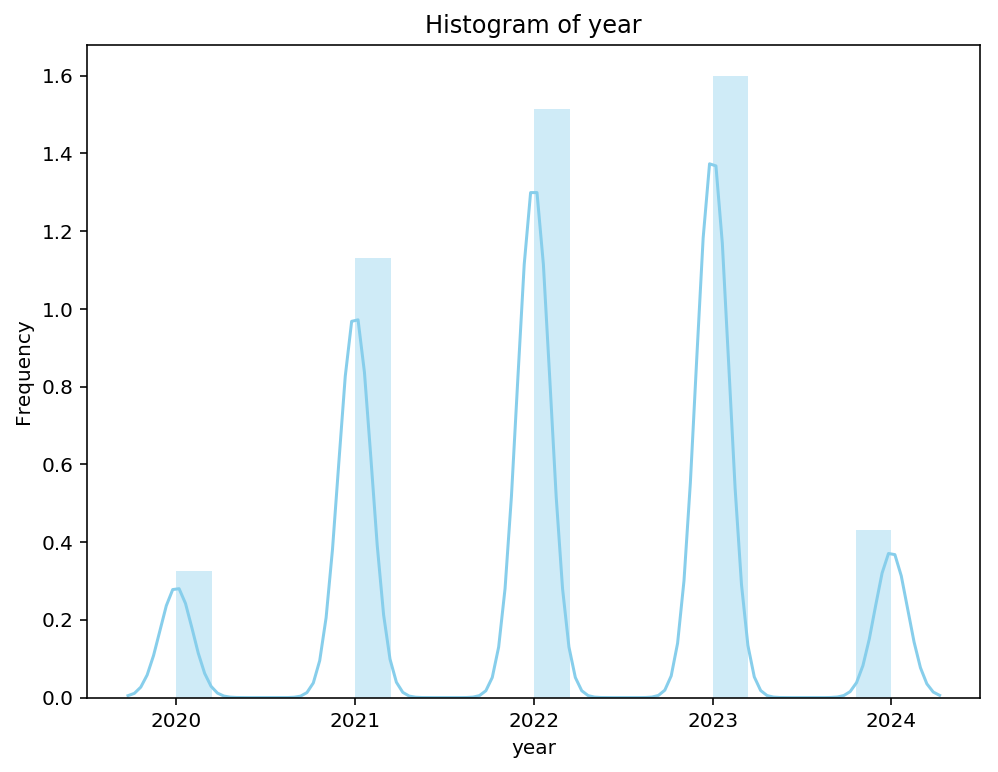

<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, 'Histogram of Water_level_lat')

Text(0.5, 0, 'Water_level_lat')

Text(0, 0.5, 'Frequency')

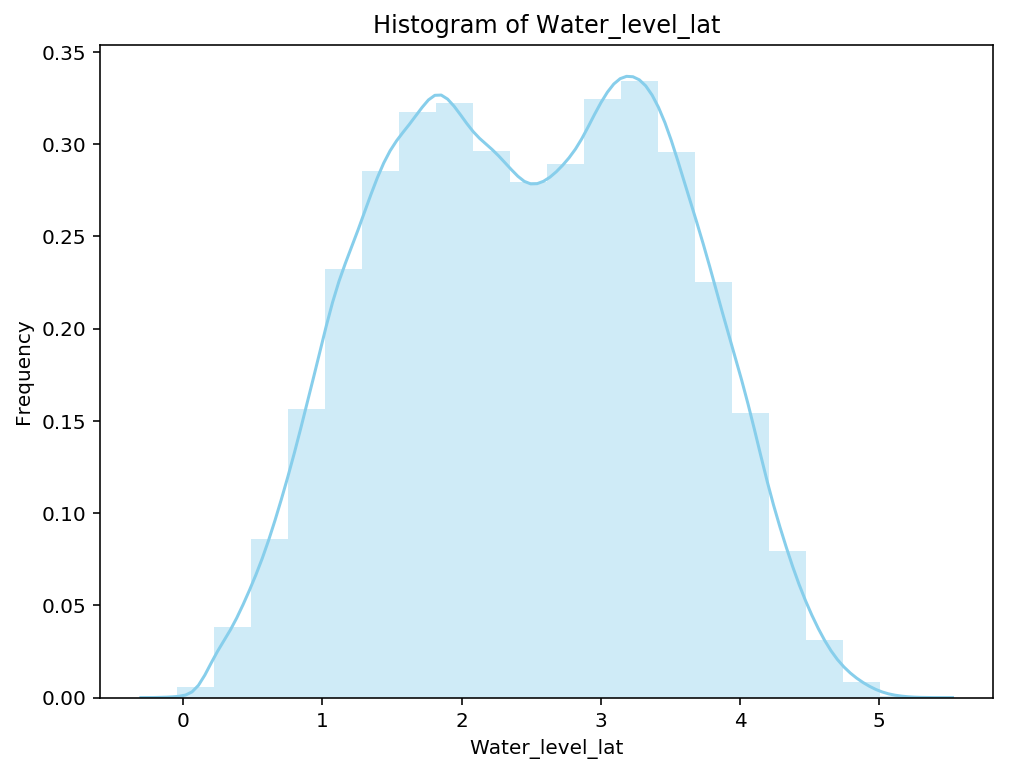

<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, 'Histogram of Water_level_Od_malin')

Text(0.5, 0, 'Water_level_Od_malin')

Text(0, 0.5, 'Frequency')

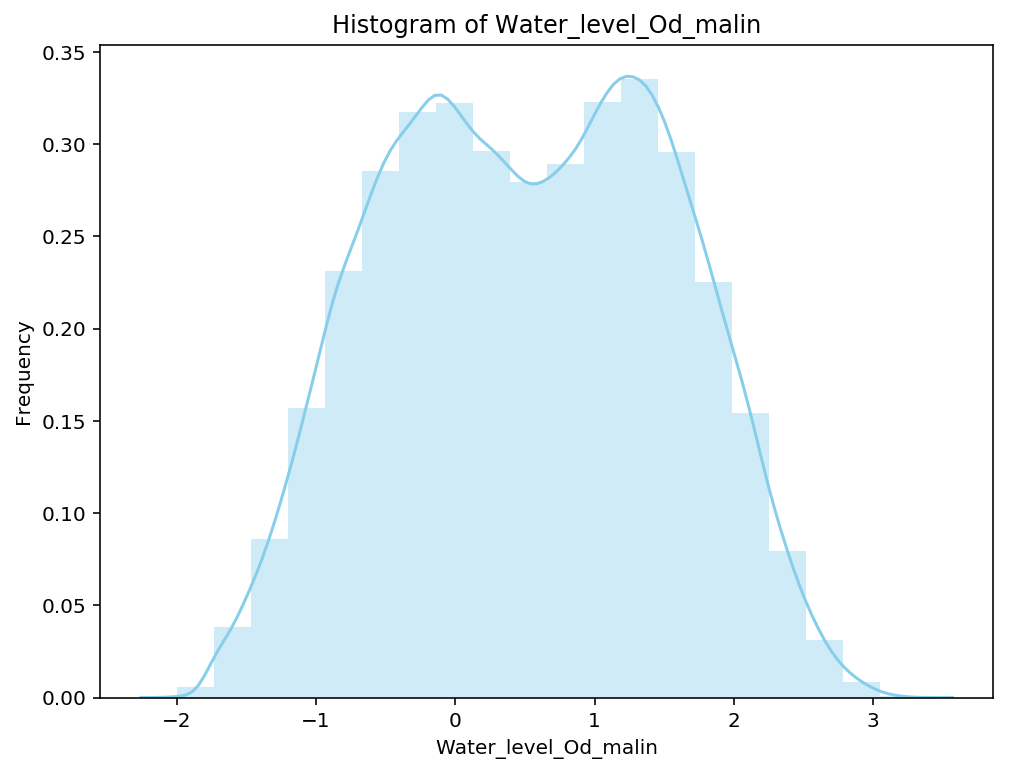

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# PySpark DataFrame to Pandas DataFrame
df_pd = df.toPandas()


featured_columns = ['year','Water_level_lat', 'Water_level_Od_malin']
for column in featured_columns:
    plt.figure(figsize=(8, 6))
    sns.distplot(df_pd[column], kde=True, bins=20, color='skyblue')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

The variations in plot heights for the 'year' distribution indicate fluctuations in the frequency of observations across the years 2020-2024

The 'Water_level_lat' and ‘water_level_od_main’ plots suggest a subtly uniform distribution that is skewed or asymmetric at the top indicating that most of the observations are clustered around 0.32 value. The slight dip at the peak implies a decrease in the frequency of observations immediately around the peak value area, followed by an increase at higher or lower values. This pattern might be indicative of specific phenomena or measurement biases in the dataset.

Plot time series plot for water levels

<Figure size 864x432 with 0 Axes>

Text(0.5, 1.0, 'Time Series Plot of Water Level (Latitude)')

Text(0.5, 0, 'Timestamp')

Text(0, 0.5, 'Water Level (m)')

(array([2019.5, 2020. , 2020.5, 2021. , 2021.5, 2022. , 2022.5, 2023. ,
        2023.5, 2024. , 2024.5]), <a list of 11 Text xticklabel objects>)

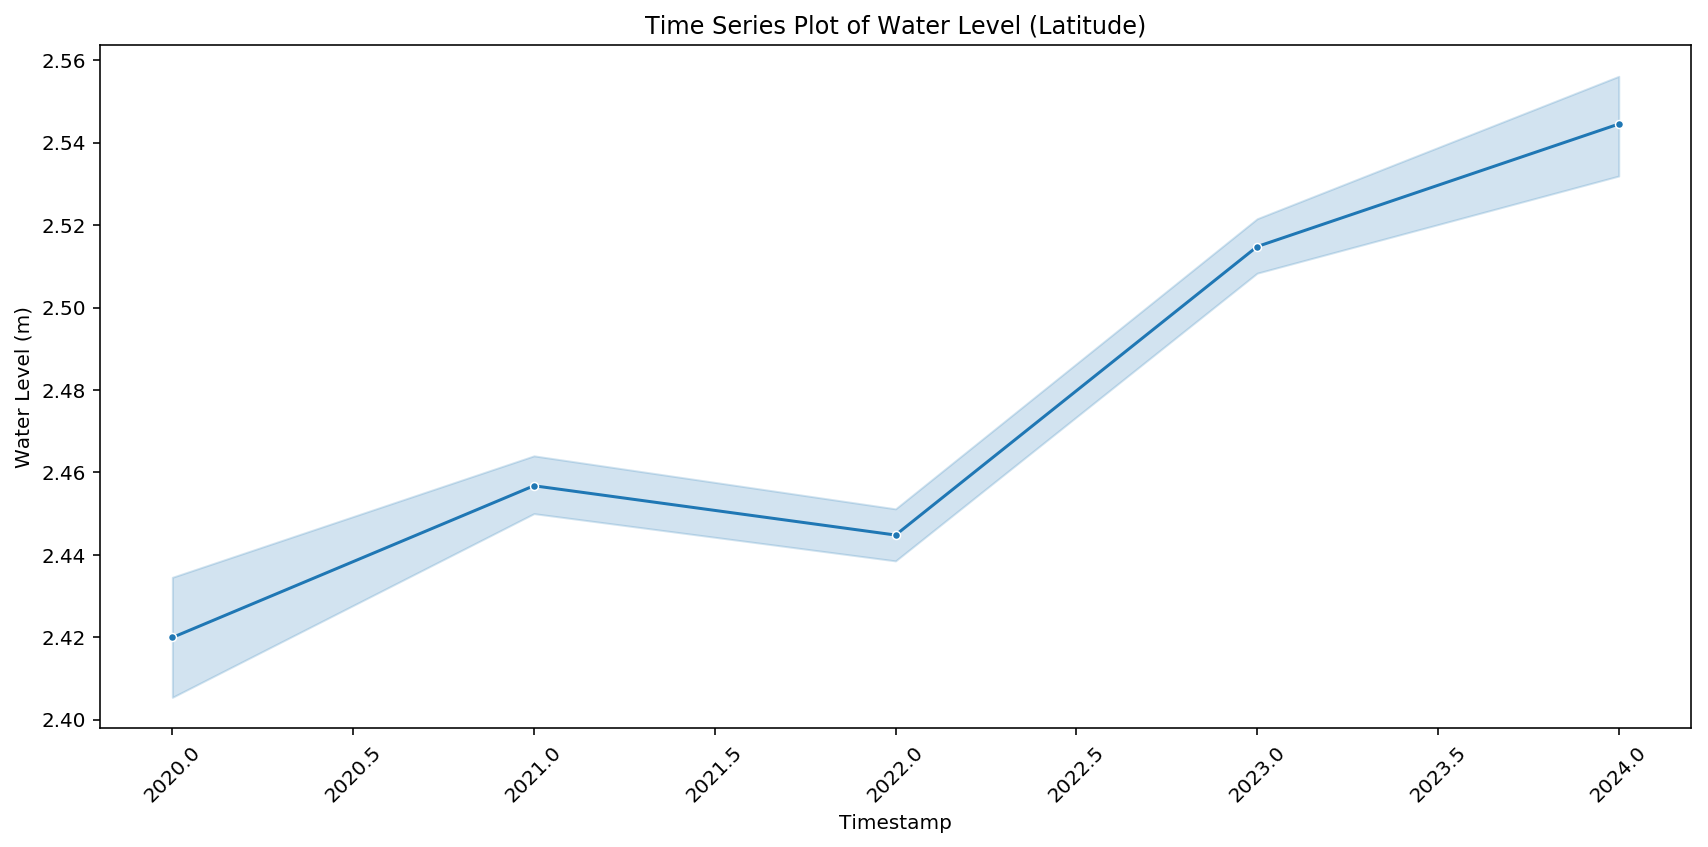

In [81]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='Water_level_lat', data=df_pd, marker='o', markersize=4)
plt.title('Time Series Plot of Water Level (Latitude)')
plt.xlabel('Timestamp')
plt.ylabel('Water Level (m)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Despite the fluctuations, there seems to be an overall progressive increase in water level between 2020 and 2024, even-though those of 2021 - 2022 had dipped before a resurgence

FIND CORRELATION
Calculate correlation matrix

<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, 'Correlation Heatmap')

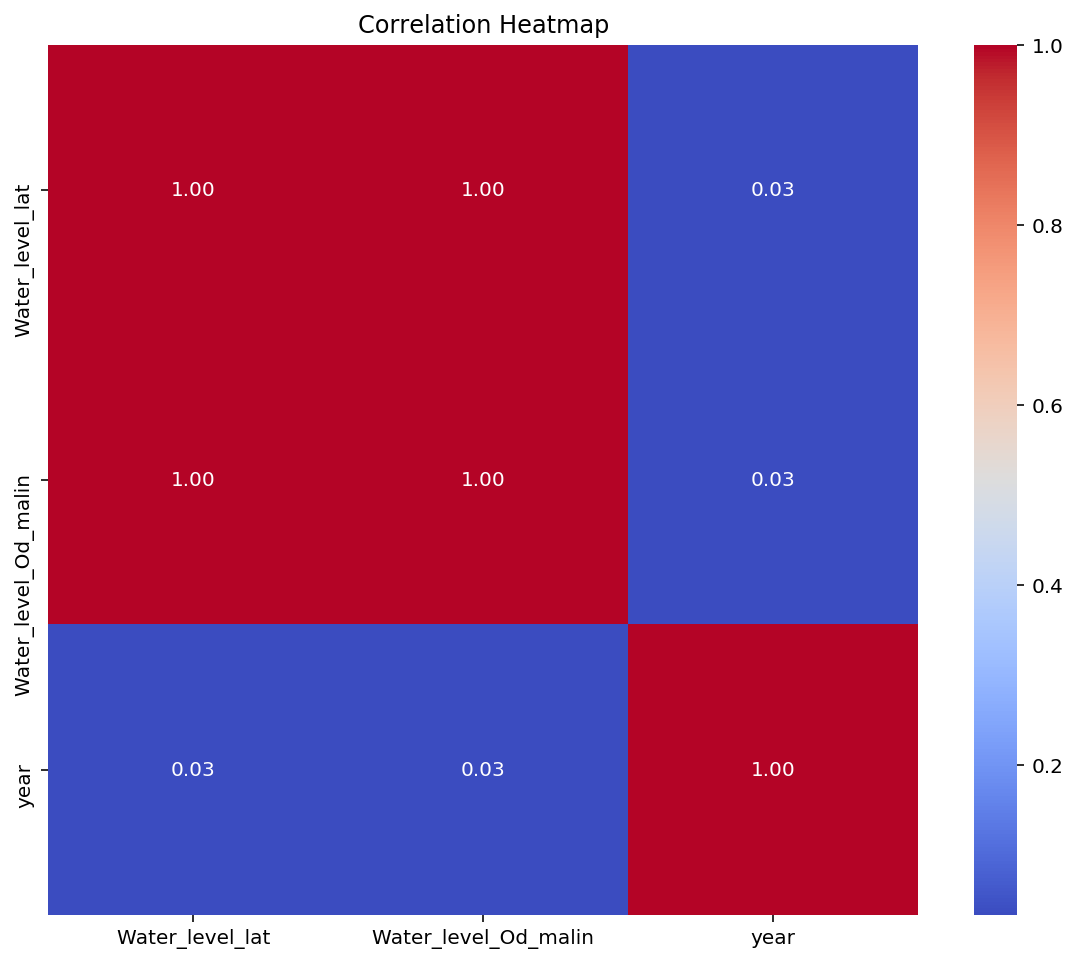

In [82]:
correlation_matrix = df.select([col for col in df.columns if col in featured_columns]).toPandas().corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.show()

The heatmap plot above shows a positive inverse correlation between water_level_lat and water_level_od_main

In [83]:
df.show(1)

+--------+---------+---------------+--------------------+-------+------+-----+----+----+------+------+
|latitude|longitude|Water_level_lat|Water_level_Od_malin|qc_flag|  year|month| day|hour|minute|second|
+--------+---------+---------------+--------------------+-------+------+-----+----+----+------+------+
|53.76235| -9.90442|          1.597|              -0.358|    0.0|2020.0|  9.0|17.0|15.0|  15.0|   0.0|
+--------+---------+---------------+--------------------+-------+------+-----+----+----+------+------+
only showing top 1 row



In [84]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import pipeline

In [85]:
# Define feature vectors

In [86]:
# features = ['latitude',
#  'longitude',
#  'Water_level_lat',
#  'Water_level_Od_malin',
#  'qc_flag',
#  'year',
#  'month',
#  'day',
#  'hour',
#  'minute',
#  'second']
features = ['latitude',
 'qc_flag',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second']

In [87]:
assembler = VectorAssembler(inputCols=features, outputCol="features")

In [88]:
df = assembler.transform(df)

In [89]:
df.show(1)

+--------+---------+---------------+--------------------+-------+------+-----+----+----+------+------+--------------------+
|latitude|longitude|Water_level_lat|Water_level_Od_malin|qc_flag|  year|month| day|hour|minute|second|            features|
+--------+---------+---------------+--------------------+-------+------+-----+----+----+------+------+--------------------+
|53.76235| -9.90442|          1.597|              -0.358|    0.0|2020.0|  9.0|17.0|15.0|  15.0|   0.0|[53.7623481750488...|
+--------+---------+---------------+--------------------+-------+------+-----+----+----+------+------+--------------------+
only showing top 1 row



In [90]:
train_data, test_data = df.randomSplit([0.8,0.2],seed=43)

In [91]:
from pyspark.ml.regression import LinearRegression

In [92]:
linear_regression = LinearRegression(featuresCol='features',labelCol='Water_level_lat')

In [93]:
lr_model= linear_regression.fit(train_data)

In [94]:
from pyspark.ml.evaluation import RegressionEvaluator

In [95]:
# Predictions on the test data
predictions = lr_model.transform(test_data)

In [96]:
# Evaluate the linear regression model
evaluator = RegressionEvaluator(labelCol='Water_level_lat', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 1.0028212393725655


In [97]:
from pyspark.ml.regression import DecisionTreeRegressor

In [98]:
decision_tree = DecisionTreeRegressor(featuresCol='features', labelCol='Water_level_lat')

In [99]:
dt_model = decision_tree.fit(train_data)

In [100]:
dt_predictions = dt_model.transform(test_data)

In [101]:
# Evaluate the model
dt_evaluator = RegressionEvaluator(labelCol='Water_level_lat', predictionCol='prediction', metricName='rmse')

In [102]:
dt_rmse = dt_evaluator.evaluate(dt_predictions)
print("Decision Tree RMSE:", dt_rmse)

Decision Tree RMSE: 0.9447245252444495
